In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

%matplotlib inline


In [2]:
df = pd.read_csv('SMSSpamCollection.txt', delimiter='\t', header=None, names=['Class', 'Text'])

In [3]:
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


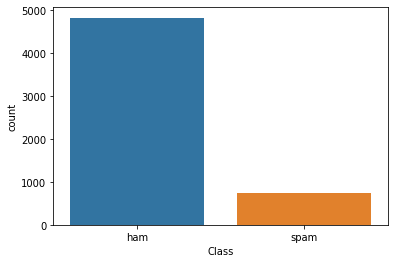

In [4]:
sns.countplot(x='Class', data=df)

In [5]:
for_del = np.random.choice(
    df[df.Class == 'ham'].index,
    df.Class.value_counts().ham - df.Class.value_counts().spam,
    replace=False
)

In [6]:
df.drop(for_del, inplace=True)

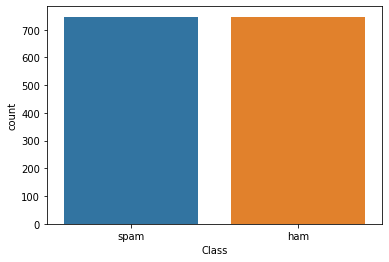

In [7]:
sns.countplot(x='Class', data=df)

In [8]:
df.Class = df.Class.map({'spam':-1, 'ham': 1})

In [9]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'
def plot_confusion(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted: True','Predicted: False'], index=['Actual: True','Actual: False'])
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False)

In [10]:
train_sms, test_sms, train_labels, test_labels = \
    train_test_split(df.Text, df.Class, random_state=42)
    
with open('sms_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_sms, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('sms_test.vw', 'w') as vw_test_data:
    for text in test_sms:
        vw_test_data.write(to_vw_format(text))

In [11]:
!vw -d sms_train.vw --loss_function hinge -f sms_model.vw

final_regressor = sms_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = sms_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000       21
1.024146 1.048293            2            2.0   1.0000  -0.0483        7
1.048932 1.073718            4            4.0  -1.0000   0.1013       21
1.056568 1.064203            8            8.0   1.0000  -0.0925        9
1.039301 1.022034           16           16.0   1.0000  -1.0000       38
0.898950 0.758600           32           32.0  -1.0000  -0.0007       17
0.755898 0.612846           64           64.0  -1.0000  -0.1348       14
0.696821 0.637744          128          128.0   1.0000   0.1513        6
0.573720 0.450618          256          256.0   1.0000   0.4968        5
0.434920 0.296120          512    

In [12]:
!vw -i sms_model.vw -t -d sms_test.vw -p sms_test_predictions.txt

only testing
predictions = sms_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = sms_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000        7
    n.a.     n.a.            2            2.0  unknown   0.8389        5
    n.a.     n.a.            4            4.0  unknown   1.0000        7
    n.a.     n.a.            8            8.0  unknown   1.0000        5
    n.a.     n.a.           16           16.0  unknown   0.3395       18
    n.a.     n.a.           32           32.0  unknown  -0.2931       19
    n.a.     n.a.           64           64.0  unknown  -1.0000       19
    n.a.     n.a.          128          128.0  unknown  -0.7880       11
    n.a.     n.a.          256          256.0  unknown   1.0000       10

finished run


findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


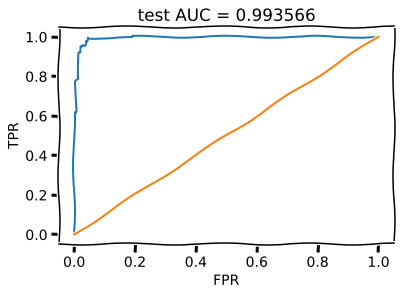

In [13]:
with open('sms_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc[0], roc[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [14]:
print(classification_report(test_labels.map({-1: 0, 1:1}),[int(prob > 0) for prob in test_prediction]))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       188
           1       0.94      0.99      0.97       186

    accuracy                           0.97       374
   macro avg       0.97      0.97      0.97       374
weighted avg       0.97      0.97      0.97       374



In [15]:
confusion_matrix(test_labels.map({-1: 0, 1:1}), [int(prob > 0) for prob in test_prediction])

array([[177,  11],
       [  1, 185]])

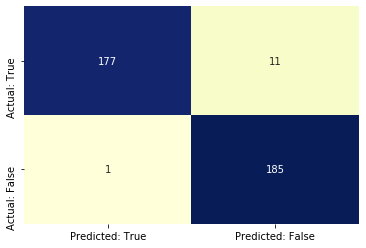

In [16]:
plot_confusion(test_labels.map({-1: 0, 1:1}), [int(prob > 0) for prob in test_prediction])